### Model inspired by:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] Modelling and Control of Offshore Marine Pipeline during Pipelay. Gullik A. Jensen et al

### Motion equation used:
M(q)q ̈ + C(q,q ̇)q ̇ + H(q,q ̇)q ̇ + f(q) + g(q) = τ

### Implementation aspects:

- This implementation is more like pseudo steady-state finite difference method (i.e. the model can be applied to normal dynamic pipelay condition as a rough estimate)

In [1]:
import numpy as np
import math
from scipy.integrate import odeint, ode, solve_ivp
from scipy.integrate import ode
from scipy.misc import derivative
from numpy.linalg import inv, pinv
import numdifftools as nd
import tqdm
import functools
from datetime import datetime
from scipy.optimize import fsolve
from scipy.linalg import lu_factor, lu_solve
from scipy.sparse.linalg import gmres

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

### Modelling data:

In [4]:
N = 16  # Number of simulation nodes

In [5]:
pipe_weight_per_unit_length = 59 #  (submerged) [kg/m]  

In [6]:
h = 40 # water depth, [m]

In [7]:
dq = np.zeros(N) #  these numbers are used for in itial checks only and redefined below

In [8]:
# Catenary

In [9]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]

In [10]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [11]:
# Note:
# steady_state_factor, assume accelerations to be small, i.e. normal dynamic pipelay condition;
# the closer the steady_state_factor to unity, the higher the acceleration

In [12]:
steady_state_factor = 1000

In [13]:
Fx_0 = 604.76664*1000 # [N] (check catenary calculation script) 
Fx_ = 552.96894*1000 # [N] (check catenary calculation script) 

In [14]:
LTD = 255.21207 # [m] (check catenary calculation script) 

In [15]:
freeSpan=2*(Fx_0/Ws)*(np.sinh(LTD*Ws/(2*Fx_0)))

In [16]:
freeSpan

255.84693682223448

In [17]:
delta_x = freeSpan/(N-1)

In [18]:
x0 = [i*delta_x for i in range(N+1)]
y0 = []
for i in range(len(x0)):
    y0.append(catenary(x0[i],Ws,Fx_))

In [19]:
q=[]
l=[]
rad_=[0]

for i in range(len(x0)-1):
    l.append(np.sqrt((x0[i+1]-x0[i])**2+(y0[i+1]-y0[i])**2))
    rad =math.atan((y0[i+1]-y0[i])/(x0[i+1]-x0[i]))
    q.append(rad-rad_[-1]) 
    rad_.append(rad)

In [20]:
l

[17.057142021190536,
 17.062578877064297,
 17.073454321591207,
 17.08977182088281,
 17.11153657548862,
 17.13875552205497,
 17.17143733553809,
 17.209592431971313,
 17.25323297178786,
 17.30237286370001,
 17.357027769135883,
 17.417215107235165,
 17.482954060405596,
 17.55426558044178,
 17.631172395207944,
 17.713699015887446]

In [21]:
pipe_joint_length = l[0]  # [m]
mn = 39_989_000 # mass of the vessel, [kg]
mn *= 9.81 # [N]

In [22]:
# L - the hull length
# Xg - x-center of gravity

L = 169 # [m]
Xg = 78 # [m]

In [23]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz = mn*Xg**2 + Ir
    return Iz

In [24]:
In = vessel_inertia_moment(mn, Xg, L)

In [25]:
In

3086970974465.625

In [26]:
mi = [x*pipe_weight_per_unit_length for x in l] # mass of pipe element (submerged), [kg]

In [27]:
# for hydrodynamic damping matrix
Cd=[0.87 for x in range(N)] # Drag coefficient
Cd[-1] = 1.6 

In [28]:
# Pipe
qw = 1025 # Water density [kg/m3]
d0 = 0.508 # Outer diameter of pipe, [m]
dI= (508-22.1*2)/1000 # Inner diameter of pipe, [m]

In [29]:
# for vector of spring forces in the pipe joints
E = 207e9 # modulus of elasticity of steel, [N/m^2]
EI = E*3.14/64*(d0**4-dI**4) # Bending stiffness [N*m^2]

In [30]:
K = EI

In [31]:
K

206414622.87219036

In [32]:
# for vector of control inputs (to control S-lay shape, can be adjusted for a certain stinger angle)
tau_qn = -6e6 # tension in pipe at water level, [N] 

In [33]:
# Time integration params:
max_t = 600
dt = 0.5
t = np.arange(0,max_t,dt)
DP_start = 10
X_REF = 0

In [34]:
Awp = 6000 # the waterplane area of the vessel, [m^2]
fip = 1e12

In [35]:
kp = 2.95e4
kd = 2.5e4

### System inertia matrix 

In [36]:
def alpha(q):
    sum_=0
    ans=[]
    for i in range(len(q)):
        sum_+=q[i]
        ans.append(sum_)
    return np.array(ans)

In [37]:
def Jv(q, i, l):
    alp=alpha(q)
    def Jv0(i, k, alp, l):
        
        if k<i:
            tmp1=np.dot(np.array(l[k:i]),np.sin(alp[k:i]))
            tmp1=-tmp1-0.5*l[i]*np.sin(alp[i])
            
            tmp2 =np.dot(np.array(l[k:i]),np.cos(alp[k:i]))
            tmp2=tmp2+0.5*l[i]*np.cos(alp[i])
                        
            return np.array([tmp1, tmp2]).T
        elif k==i:
            return np.array([-0.5*l[i]*np.sin(alp[i]),
                    0.5*l[i]*np.cos(alp[i])]).T
        else:
            return np.array([0, 0]).T                 
    
    ans=np.array([Jv0(i, k, alp, l) for k in range(len(q))])
    
    return ans.T

In [38]:
Jv(q, 2, l)

array([[-0.98984601, -0.83758814, -0.380766  ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [42.64115614, 25.58469368,  8.52823123,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]])

In [39]:
def Jomega(i,q):

    def Jomega0(i,k):
        if k<=i:
            return 1
        return 0
    ans=np.array([Jomega0(i, k) for k in range(len(q))])
   
    return ans.reshape(len(q),1).T

In [40]:
def M(q, l, mn, In, mi):
  
    sum1 = mn * np.dot(Jv( q, len(q)-1, l).T, Jv(q, len(q)-1, l))
    
    sum2 = In * np.dot(Jomega(len(q)-1,q).T, Jomega(len(q)-1,q))

    sum3 = 0
    
    for i in range(len(q)-1):
        J_v = Jv(q, i, l)
        sum3+=mi[i]*np.dot(J_v.T, J_v)
      
    return (sum1 + sum2 + sum3)*steady_state_factor  

In [41]:
M(q, l, mn, In, mi)

array([[3.10390394e+16, 2.92678400e+16, 2.74922377e+16, 2.57122308e+16,
        2.39278161e+16, 2.21389889e+16, 2.03457432e+16, 1.85480716e+16,
        1.67459652e+16, 1.49394138e+16, 1.31284057e+16, 1.13129279e+16,
        9.49296594e+15, 7.66850381e+15, 5.83952420e+15, 4.00600835e+15],
       [2.92678400e+16, 2.76107806e+16, 2.59493364e+16, 2.42835055e+16,
        2.26132847e+16, 2.09386693e+16, 1.92596534e+16, 1.75762295e+16,
        1.58883889e+16, 1.41961215e+16, 1.24994154e+16, 1.07982579e+16,
        9.09263431e+15, 7.38252893e+15, 5.66792446e+15, 3.94880221e+15],
       [2.74922377e+16, 2.59493364e+16, 2.44021048e+16, 2.28505408e+16,
        2.12946413e+16, 1.97344016e+16, 1.81698159e+16, 1.66008769e+16,
        1.50275758e+16, 1.34499027e+16, 1.18678460e+16, 1.02813929e+16,
        8.69052913e+15, 7.09523908e+15, 5.49550569e+15, 3.89131049e+15],
       [2.57122308e+16, 2.42835055e+16, 2.28505408e+16, 2.14133348e+16,
        1.99718840e+16, 1.85261840e+16, 1.70762291e+16, 1.562

### Coriolis-centripetal matrix

In [42]:
def C(q, dq, l, mn, In, mi): 
    ans = np.zeros((len(q),len(q)))              
    fun = lambda q: M(q, l, mn, In, mi)
    Dfun = nd.Gradient(fun) 
    
    diff = Dfun(q)

    
    def c(i,j,k):
        return 0.5 *(diff[k].item((i,j))+
                     diff[j].item((i,k))-
                     diff[i].item((j,k)))
    
    for i in range(len(q)):
        for j in range(len(q)):
            for k in range(len(q)):
                ans[i][j]+=c(i,j,k)*dq[k]
    return ans    

In [43]:
C(q, dq, l, mn, In, mi)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

### Hydrodynamic damping matrix

In [44]:
def R_I_Bi(i, alp):
    return np.array([[np.cos(alp[i]), -np.sin(alp[i])],
                    [np.sin(alp[i]), np.cos(alp[i])]])

In [45]:
alp=alpha(q)
dalp=alpha(dq)

In [46]:
R_I_Bi(2, alp)

array([[ 0.99900478, -0.04460328],
       [ 0.04460328,  0.99900478]])

In [47]:
I_=np.array([[0,0],
             [0,1]])

In [48]:
def Pi(i,alp):
    return np.dot(np.dot(R_I_Bi(i, alp),I_),R_I_Bi(i, alp).T)

In [49]:
def mod_Vn(q, alp, dq):
    ans=[]
    for j in range(len(q)):
        ans.append(np.dot(np.dot(Pi(j,alp),Jv( q,j, l)), dq))
    return np.linalg.norm(np.array(ans))

In [50]:
mod_Vn(q,alp,dq)

0.0

In [51]:
def mod_Vni(i,q,alp,dq):
    return np.linalg.norm(np.dot(np.dot(Pi(i,alp),Jv( q,i, l)), dq))

In [52]:
mod_Vni(len(q)-1,q,alp,dq)

0.0

In [53]:
def gamma(i):
    return 0.5*Cd[i]*qw*d0*l[i]

In [54]:
def H(alp,q,dq,l):
    ans=np.zeros((len(q), len(q)))
    alp=alpha(q)
    for j in range(len(q)):
        ans+=gamma(j)*mod_Vni(j,q,alp,dq)*np.dot(np.dot(Jv(q,j,l).T,Pi(j,alp)),Jv( q,j, l))
    return ans    

In [55]:
alp

array([0.00892646, 0.02677653, 0.04461808, 0.06244542, 0.08025292,
       0.09803494, 0.11578593, 0.13350034, 0.15117271, 0.16879763,
       0.18636977, 0.20388387, 0.22133479, 0.23871745, 0.25602688,
       0.27325824])

In [56]:
H(alp,q,dq,l)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

### Vector of spring forces in the pipe joints

In [57]:
def f(q,k):
    ans=np.array([k*q[i] for i in range(len(q))])
    return ans.reshape(len(q),1)

### Vector of gravitational/buoyancy forces

In [58]:
def x(alp,i,l):
    tmp1=np.dot(np.array(l[:i]),np.cos(alp[:i]))

    tmp1+=0.5*l[i]*np.cos(alp[i])
    return tmp1

In [59]:
x(alp,2,l)

42.64115613703909

In [60]:
def y(alp,i,l):
    tmp1=np.dot(np.array(l[:i]),np.sin(alp[:i]))
    tmp1+=0.5*l[i]*np.sin(alp[i])
    return tmp1

In [61]:
y(alp,2,l)

0.9898460079596942

In [62]:
G=np.array([0,-9.81]).T

def ggi(i,G):
    return mi[i]*G
   
    
def gbi(G,l,i):
    return -3.14*l[i]*(d0**2/4)*qw*G 


def gt(alp, dalp, fip, i): 
    return -fip*(alp[i] - dalp[i])


In [63]:
def g(q, alp, dalp):
    sum_=0
    for i in range(len(q)-1):
        sum_+=np.dot(Jv( q,i, l).T,ggi(i,G)+gbi(G,l,i))
    tmp = -qw*Awp*(y(alp,len(alp)-1,l)-h)*G 
    sum_ += np.dot(Jv(q,len(q)-1, l).T, tmp) 
    ans = sum_.reshape(len(q),1) +np.dot(Jomega(len(q)-1,q).T, gt(alp,dalp,fip, len(q)-1))
    return  ans 

In [64]:
g(q,alp, dalp)

array([[-3.23412354e+11],
       [-3.20179698e+11],
       [-3.16946617e+11],
       [-3.13713112e+11],
       [-3.10479182e+11],
       [-3.07244827e+11],
       [-3.04010046e+11],
       [-3.00774838e+11],
       [-2.97539203e+11],
       [-2.94303139e+11],
       [-2.91066646e+11],
       [-2.87829721e+11],
       [-2.84592364e+11],
       [-2.81354573e+11],
       [-2.78116346e+11],
       [-2.74877681e+11]])

### Vector of control inputs

In [65]:
# Assume that the stinger is shorter than the link length li for any link i
def tau_q(q,tau_qn): 
    ans= np.array([0 for i in range(len(q))]).reshape(len(q),1)
    ans[-1] = tau_qn
    return ans

In [66]:
def Fx(q,alp,dq,kp, kd, x_ref = 0):
    return -kp*(x(alp,len(q)-1,l)-x_ref) - kd*mod_Vn(q,alp,dq)

In [67]:
Fx(q,alp,dq,kp, kd, x_ref = 0)

-7799067.457464448

In [68]:
F1=np.array([Fx_,0]).reshape(2,1) # actuates the vessel in the surge direction in frame Bn
def tau_t(q, F):
    tmp= np.dot(Jv(q,len(q)-1, l).T, F)
    return tmp

In [69]:
tau_t(q, F1)

array([[-20378301.79695475],
       [-20294107.92478833],
       [-20041499.47273867],
       [-19620395.92560142],
       [-19030663.06285496],
       [-18272112.91587947],
       [-17344503.70804555],
       [-16247539.77765038],
       [-14980871.48368068],
       [-13544095.09436957],
       [-11936752.65851304],
       [-10158331.85950472],
       [ -8208265.85204291],
       [ -6085933.08145655],
       [ -3790657.08559409],
       [ -1321706.27921122]])

In [70]:
y(alp,0,l),y(alp,len(q)-1,l)

(0.07612893426384613, 36.852525201424065)

In [71]:
tau_q_wave=9e6 # (taken from article on forces to semi-submersible platform),[N]
def tau_wave(q, alp, tau_q_wave): 
    A0 = tau_q_wave         
    k = 0.5          
    ans=[]
    for i in range(len(q)):
        ans.append([tau_q_wave * np.exp(-k * (y(alp,len(q)-1,l)-y(alp,i,l)))  ])   
    return np.array(ans)

In [72]:
def tau(q, alp, tau_qn, F, tau_q_wave):
    return tau_t(q, F) + tau_wave(q, alp, tau_q_wave) +tau_q(q,tau_qn)

In [73]:
tau_wave(q,alp, tau_q_wave)

array([[9.29714336e-02],
       [1.08262873e-01],
       [1.46811701e-01],
       [2.31864922e-01],
       [4.26546081e-01],
       [9.14192729e-01],
       [2.28326329e+00],
       [6.64733179e+00],
       [2.25662694e+01],
       [8.93639632e+01],
       [4.12995977e+02],
       [2.22854732e+03],
       [1.40483034e+04],
       [1.03515821e+05],
       [8.92168509e+05],
       [9.00000000e+06]])

In [74]:
tau(q, alp, tau_qn, F1, tau_q_wave)

array([[-20378301.70398332],
       [-20294107.81652546],
       [-20041499.32592697],
       [-19620395.69373649],
       [-19030662.63630887],
       [-18272112.00168674],
       [-17344501.42478226],
       [-16247533.13031859],
       [-14980848.91741127],
       [-13544005.73040641],
       [-11936339.66253559],
       [-10156103.31218023],
       [ -8194217.54866904],
       [ -5982417.26025883],
       [ -2898488.57640118],
       [  1678293.72078878]])

In [75]:
q

[0.008926459683839327,
 0.017850074644181497,
 0.01784154500477122,
 0.017827344025214124,
 0.017807494273221258,
 0.017782027220999932,
 0.017750983124132327,
 0.01771441086657112,
 0.017672367774230063,
 0.017624919397368627,
 0.017572139263887898,
 0.017514108605026557,
 0.01745091605552268,
 0.017382657329900686,
 0.017309434877491064,
 0.017231357518113277]

### Static solution

In [76]:
alp_=alpha(q)

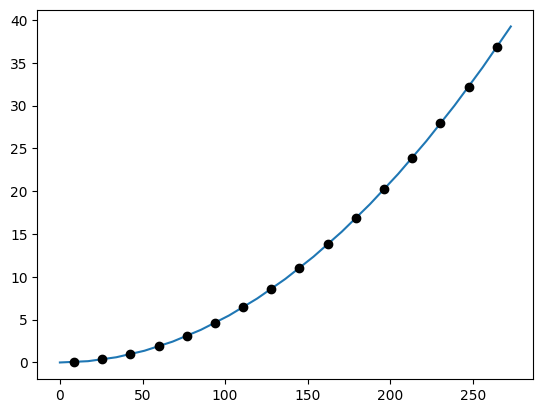

In [77]:
plt.plot(x0, y0)
for i in range(len(q)):
    plt.plot(x(alp_,i,l),y(alp_,i,l), 'o', color='black')
plt.show()

In [78]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    q0.append(0)

In [79]:
dq

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [80]:
q

[0.008926459683839327,
 0.017850074644181497,
 0.01784154500477122,
 0.017827344025214124,
 0.017807494273221258,
 0.017782027220999932,
 0.017750983124132327,
 0.01771441086657112,
 0.017672367774230063,
 0.017624919397368627,
 0.017572139263887898,
 0.017514108605026557,
 0.01745091605552268,
 0.017382657329900686,
 0.017309434877491064,
 0.017231357518113277]

In [81]:
def static_func(q):
    alp=alpha(q)
    dalp=alpha(dq)
    F_=np.array([-Fx(q,alp,dq,kp, 0, x_ref = 0),0]).reshape(2,1)
    ans=  f(q, K)-g(q,alp,dalp) - tau(q,alp, tau_qn, F_, 0)
    return ans.reshape((len(q),))

In [82]:
root = fsolve(static_func, np.array(q).astype(np.float64))

In [83]:
root

array([ 0.10481192,  0.04591658,  0.01915924,  0.00700666,  0.00148128,
       -0.00104167, -0.00221412, -0.00280059, -0.00318037, -0.00359706,
       -0.00431957, -0.00582176, -0.00910144, -0.01635584, -0.03247541,
       -0.09744334])

In [84]:
q = list(root) 

In [85]:
q

[0.10481192476114787,
 0.04591658265845228,
 0.019159235964503574,
 0.007006659062889306,
 0.0014812754083785831,
 -0.0010416717419633986,
 -0.0022141240356808585,
 -0.0028005862838351536,
 -0.003180370751548108,
 -0.0035970598496236445,
 -0.004319571591113551,
 -0.005821759220306215,
 -0.009101438916266113,
 -0.016355844157911335,
 -0.0324754102004963,
 -0.0974433435265152]

In [86]:
q0=[]
for i in range(len(q)):
    q0.append(q[i])
    q0.append(0)

In [87]:
alp_=alpha(root) 

In [88]:
alp_

array([1.04811925e-01, 1.50728507e-01, 1.69887743e-01, 1.76894402e-01,
       1.78375678e-01, 1.77334006e-01, 1.75119882e-01, 1.72319296e-01,
       1.69138925e-01, 1.65541865e-01, 1.61222294e-01, 1.55400534e-01,
       1.46299095e-01, 1.29943251e-01, 9.74678411e-02, 2.44975801e-05])

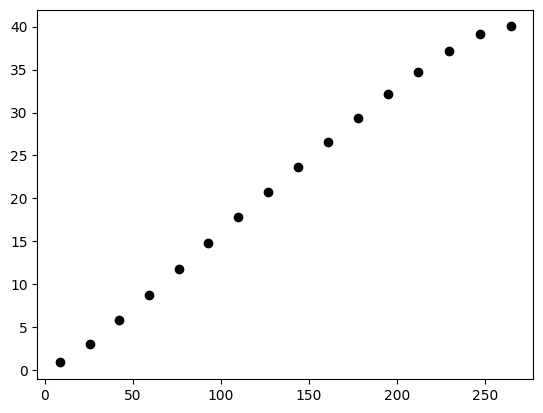

In [89]:
for i in range(len(q)):
    plt.plot(x(alp_,i,l),y(alp_,i,l), 'o', color='black')
plt.show()

In [90]:
q0

[0.10481192476114787,
 0,
 0.04591658265845228,
 0,
 0.019159235964503574,
 0,
 0.007006659062889306,
 0,
 0.0014812754083785831,
 0,
 -0.0010416717419633986,
 0,
 -0.0022141240356808585,
 0,
 -0.0028005862838351536,
 0,
 -0.003180370751548108,
 0,
 -0.0035970598496236445,
 0,
 -0.004319571591113551,
 0,
 -0.005821759220306215,
 0,
 -0.009101438916266113,
 0,
 -0.016355844157911335,
 0,
 -0.0324754102004963,
 0,
 -0.0974433435265152,
 0]

In [91]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, [q])))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, [q])))

add6=functools.partial(g,alp=alp_, dalp=dalp)
add6__g =np.array(list(map(add6, [q])))

print(datetime.now() - startTime)

0:00:00.006425


In [92]:
tmp__1 = pinv(add1__Jv.transpose(0, 2, 1))
tmp__2 = add5__f + add6__g

In [93]:
tmp__ = np.matmul(tmp__1, tmp__2)

In [94]:
dim1 = int(max_t/dt)
dim2 = dim1-1

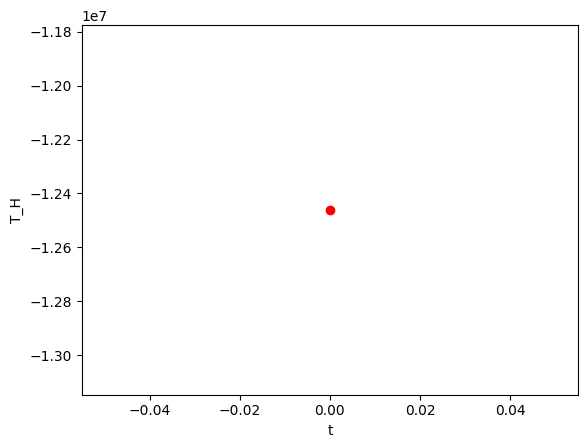

In [95]:
plt.plot(t[:len(tmp__)],tmp__[:,0],'o', color='red')
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

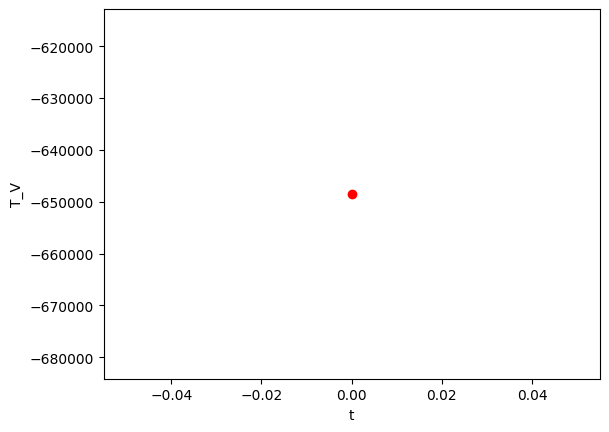

In [96]:
plt.plot(t[:len(tmp__)],tmp__[:,1],'o', color='red')
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [97]:
max(tmp__[:,0]), max(tmp__[:,1])

(array([-12460993.29503067]), array([-648490.51433549]))

In [98]:
# class myIter:
#     def __init__(self):
#         self.my_iter = 0

In [99]:
# k000=myIter()

### Dynamic solution 

In [100]:
def dynamic_func(Q, t, q):

    q, dq = Q[0::2], Q[1::2]
    QI = q.reshape(len(q),1)
    dQ = dq.reshape(len(q),1)
    
    QI = QI.flatten().tolist()
 
 
    alp = alpha(QI)
    dalp = alpha(dQ.flatten().tolist())

    if t > DP_start:
        F = np.array([-Fx(QI, alp, dQ, kp, kd, x_ref = 0),0]).reshape(2,1) 
    else:
        F = np.array([Fx_0, 0]).reshape(2,1)
    
    
    
    A = M(QI, l, mn, In, mi)
    b = (- np.dot(H(alp,QI,dQ,l), dQ).reshape(len(QI),1)
                        - np.dot(C(QI,dQ, l, mn, In, mi), dQ) 
                        - f(QI, K) 
                        - g(QI,alp, dalp) 
                        + tau(QI,alp, tau_qn, F, tau_q_wave))
    
    x = np.linalg.solve(A.astype(np.float64), b.astype(np.float64))
    
    n = np.linalg.norm(x)
    x = x / n
    
    ddq = x.flatten()
    
#     k000.my_iter+=1
      
    ans=np.array([dq , ddq]).T.flatten()
        
    return ans

In [101]:
q

[0.10481192476114787,
 0.04591658265845228,
 0.019159235964503574,
 0.007006659062889306,
 0.0014812754083785831,
 -0.0010416717419633986,
 -0.0022141240356808585,
 -0.0028005862838351536,
 -0.003180370751548108,
 -0.0035970598496236445,
 -0.004319571591113551,
 -0.005821759220306215,
 -0.009101438916266113,
 -0.016355844157911335,
 -0.0324754102004963,
 -0.0974433435265152]

In [ ]:
startTime1 = datetime.now()
us=odeint(dynamic_func, q0, t, args=(q,))
print(datetime.now() - startTime1)

In [ ]:
us_=us

In [ ]:
plt.xlabel('t')
k=0
for i in range(len(q0)):
    if i%2==0:
        plt.plot(t,us_[:,i] ,'-')
        plt.ylabel('q{}'.format(k))
    else:
        plt.plot(t, us_[:,i],'-')
        plt.ylabel('{}q{}'.format('d',k))
        k+=1
    plt.show()        

In [ ]:
horizon_start = 0

In [ ]:
plt.figure(figsize=(14,4))
plt.xlabel('X')
plt.ylabel('Y')

for j in range(len(q)):
    X = [x(alpha(us_[i,[k for k in range(0,len(q0),2)]]),j,l) for i in range(horizon_start, len(us_))]
    Y = [y(alpha(us_[i,[k for k in range(0,len(q0),2)]]),j,l) for i in range(horizon_start, len(us_))]
    X_ = [x(alpha(us_[i,[k for k in range(0,len(q0),2)]]),j,l) for i in range(1)]
    Y_ = [y(alpha(us_[i,[k for k in range(0,len(q0),2)]]),j,l) for i in range(1)]
    plt.plot(X_,Y_, 'o', color='black')
    
    # dynamic
    plt.plot(X,Y,'b')   
    
    plt.plot(x(alpha(us_[-1,[k for k in range(0,len(q0),2)]]),j,l),
             y(alpha(us_[-1,[k for k in range(0,len(q0),2)]]),j,l), 'o', color='green')
plt.show()

### Pipe-tip tension

In [ ]:
coordinates=us[:,[k for k in range(0,len(q0),2)]]
velocities=us[:,[k for k in range(0,len(q0),2)]]

In [ ]:
alp_=[]
for i in range(len(us)):
    alp_.append(alpha(coordinates[i]))
alp_=np.matrix(alp_) 


dalp_=[]
for i in range(len(us)):
    dalp_.append(alpha(velocities[i]))
dalp_=np.matrix(dalp_)   

In [ ]:
velocities.shape

In [ ]:
velocities_0 = velocities[:-1]
velocities_1 = velocities[1:]

In [ ]:
coordinates.shape, velocities.shape

In [ ]:
startTime1 = datetime.now()

add4=functools.partial(C, l=l, mn=mn, In=In, mi=mi)
add4__C =np.array(list(map(add4, coordinates, velocities)))

print(datetime.now() - startTime1)

In [ ]:
startTime = datetime.now()

add1=functools.partial(Jv, i=len(q)-1, l=l)
add1__Jv = np.array(list(map(add1, coordinates)))

add2=functools.partial(M, l=l, mn=mn, In=In, mi=mi)
add2__M =np.array(list(map(add2, coordinates)))

add3=functools.partial(H,  l=l)
add3__H =np.array(list(map(add3, alp_.tolist(), coordinates, velocities)))

add5=functools.partial(f, k=K)
add5__f =np.array(list(map(add5, coordinates)))

add6=functools.partial(g)
add6__g =np.array(list(map(add6, coordinates, alp_.tolist(),dalp_.tolist())))

print(datetime.now() - startTime)

In [ ]:
velocities_1.shape

In [ ]:
add5__f.shape

In [ ]:
add6__g.shape

In [ ]:
add3__H.shape

In [ ]:
tmp__1 = pinv(add1__Jv[:-1].transpose(0, 2, 1))
tmp__2 = np.matmul(add2__M[:-1], (velocities_1.reshape(dim2,len(q),1) - velocities_0.reshape(dim2,len(q),1))/dt)\
            + np.matmul(add3__H[:-1], velocities[:-1].reshape(dim2,len(q),1)) \
            + np.matmul(add4__C[:-1], velocities[:-1].reshape(dim2,len(q),1)) \
            + add5__f[:-1] \
            + add6__g[:-1]

In [ ]:
add1__Jv[:-1].shape

In [ ]:
tmp__2.shape

In [ ]:
tmp__=np.matmul(tmp__1, tmp__2)

In [ ]:
plt.plot(t[:len(tmp__)],tmp__[:,0],'-')
plt.xlabel('t')
plt.ylabel('T_H')
plt.show()

In [ ]:
plt.plot(t[:len(tmp__)],tmp__[:,1],'-')
plt.xlabel('t')
plt.ylabel('T_V')
plt.show()

In [ ]:
# Axial strain

In [ ]:
Af = 3.14/4*(d0**2-dI**2)

In [ ]:
np.max(tmp__[:,0])/(E*Af)

In [ ]:
np.max(tmp__[:,0])/(E*Af*steady_state_factor)

In [ ]:
np.min(tmp__[:,0])/(E*Af)

In [ ]:
np.min(tmp__[:,0])/(E*Af*steady_state_factor)

In [ ]:
# Bending strain

In [ ]:
Mmax=np.sqrt(np.max(tmp__[:,0])+np.max(tmp__[:,1]))*l[-1]

In [ ]:
W = 3.14*(d0**4-dI**4)/(32*d0)

In [ ]:
(Mmax/W)/E

In [ ]:
(Mmax/W)/(E*steady_state_factor)

In [ ]:
# Hs

In [ ]:
X111 = [x(alpha(us_[i,[k for k in range(0,len(q0),2)]]),N-4,l) for i in range(0, len(us_))]
Y111 = [y(alpha(us_[i,[k for k in range(0,len(q0),2)]]),N-4,l) for i in range(0, len(us_))]
X111_ = [x(alpha(us_[i,[k for k in range(0,len(q0),2)]]),N-4,l) for i in range(1)]
Y111_ = [y(alpha(us_[i,[k for k in range(0,len(q0),2)]]),N-4,l) for i in range(1)]

In [ ]:
(np.max(Y111)-np.min(Y111))

In [ ]:
X1111 = [x(alpha(us_[i,[k for k in range(0,len(q0),2)]]),N-3,l) for i in range(0, len(us_))]
Y1111 = [y(alpha(us_[i,[k for k in range(0,len(q0),2)]]),N-3,l) for i in range(0, len(us_))]
X1111_ = [x(alpha(us_[i,[k for k in range(0,len(q0),2)]]),N-3,l) for i in range(1)]
Y1111_ = [y(alpha(us_[i,[k for k in range(0,len(q0),2)]]),N-3,l) for i in range(1)]

In [ ]:
(np.max(Y1111)-np.min(Y1111))